# Исслелование продаж гейм-индустрии

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

## Предобработка данных

In [2]:
try:
    df = pd.read_csv(--)
except:
    df = pd.read_csv('/datasets/games.csv.')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем названия стодбцов к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()

Удалим строки с прорусками в столбцах year_of_release(тк нет подходяшей замены), name и genre тк их удаление не повлияет на результат. 

In [6]:
df = df.dropna(subset=['name'])  
df = df.dropna(subset=['year_of_release'])

Изменим тип данных в столбцах year_of_release и user_score

In [7]:
df['year_of_release'] = df['year_of_release'].astype(int)

Создадим отдельные таблицы без пропусков

In [8]:
users_score = df.loc[(df['user_score'].isna() == False) & (df['user_score'] != "tbd")].copy()
users_score['user_score'] = users_score['user_score'].astype(float)
critic_score = df.loc[df['critic_score'].isna() == False]

In [9]:
users_score.isna().sum()

name                 0
platform             0
year_of_release      0
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       569
user_score           0
rating              83
dtype: int64

In [10]:
critic_score.isna().sum()

name                0
platform            0
year_of_release     0
genre               0
na_sales            0
eu_sales            0
jp_sales            0
other_sales         0
critic_score        0
user_score         33
rating             81
dtype: int64

tbd - означает будет определено. Значит на момент записи данных не было информации о рейтинге. Заменим пропуски на медианные значения исходя из жанра.

In [11]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 0
df['user_score'] = df['user_score'].fillna(0)

In [12]:
def score(data, column, score_data):
    for genre in data['genre'].unique():
        data.loc[(data[column] == 0) & (data['genre'] == genre), column] =\
        score_data.loc[score_data['genre'] == genre, column].median()
    return data

In [13]:
df = score(df, 'user_score', users_score)

In [14]:
df['user_score'] = df['user_score'].astype(float)

По такому же принципу заменим и пропуски в столбце critic_score

In [15]:
df['critic_score'] = df['critic_score'].fillna(0)

In [16]:
df = score(df, 'critic_score', critic_score)

In [17]:
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6676
dtype: int64

Для замены пропусков в столбце rating самым подходящим основанием является жанр.

In [18]:
rating_dict = df.loc[:,['genre','rating']].copy()

In [19]:
rating_dict = rating_dict.drop_duplicates().dropna()

In [20]:
rating_dict = dict(zip(rating_dict.genre, rating_dict.rating))

In [21]:
def rating(data):
    for geners in data['genre'].unique():
        i = rating_dict.get(geners)
        data.loc[(data['genre'] == geners) & (data['rating'].isna()), 'rating'] = i
    return data

In [22]:
df = rating(df)

In [23]:
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Посчитаем общие продажи

In [24]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +df['other_sales']

## Исследовательский анализ

Посмотрим сколько игр выпускалось в разные годы.

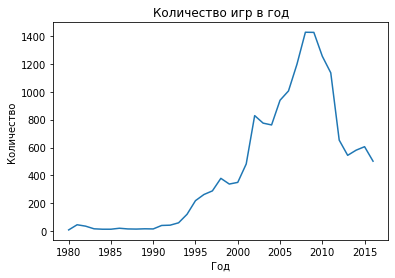

In [25]:
plt.plot(df.groupby('year_of_release')['total_sales'].count())
plt.xlabel('Год')
plt.ylabel('Количество')
plt.title('Количество игр в год')
plt.show()

Исходя из графика мы видим что количество игр начало постепенно расти начиная с 1990 года, вплоть до 2010 после чего начался спад. А наибольшее количество игр выпускалось с 2005 по 2010 год.

Посмотрим на продажи по плаформам по годам

In [26]:
platform_top = df.pivot_table(index = 'platform',
                                  values='total_sales',
                                  aggfunc='sum').sort_values('total_sales', ascending=False).head(10)

In [27]:
data_top_5_sort = df.query('platform in @platform_top.index and year_of_release > 1985')
data_top_5_final = data_top_5_sort.groupby(['platform','year_of_release'], as_index=False)[['total_sales']].sum()

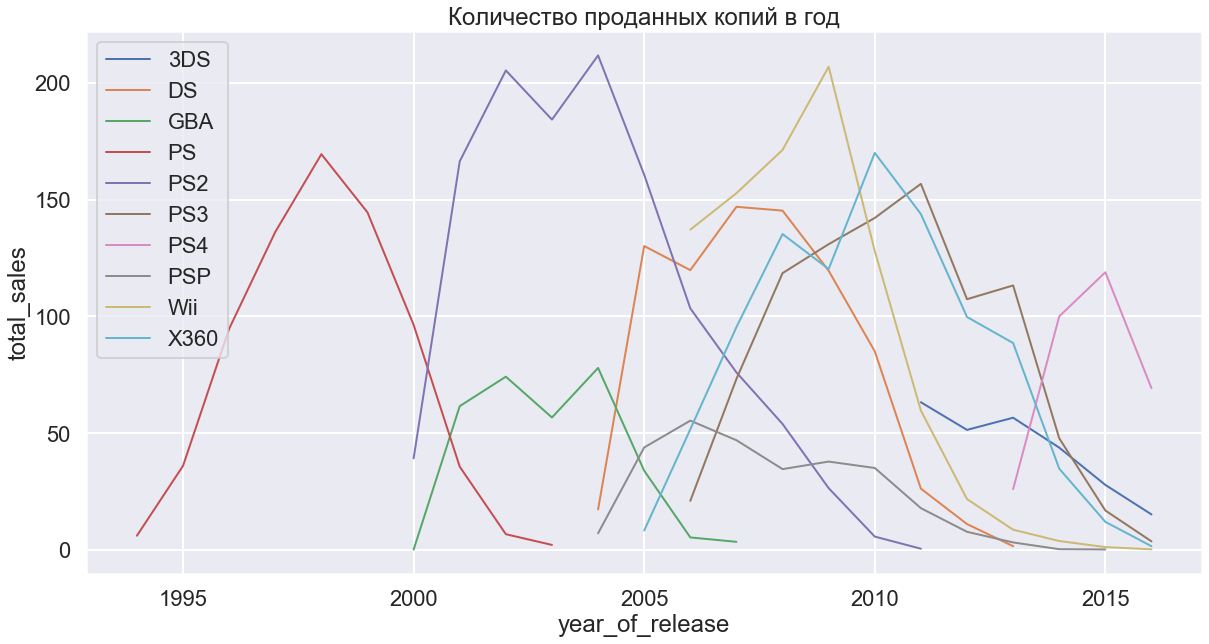

In [28]:
for i in data_top_5_final['platform'].unique():
    sns.set(rc={"figure.figsize":(20, 10)})
    sns.set_context("poster")
    plt.title('Количество проданных копий в год')
    sns.lineplot(data=data_top_5_final.loc[data_top_5_final['platform'] == i],
                 x='year_of_release',
                 y='total_sales',
                 label=i,
                 linewidth = 2)

На данном графике мы видим что с 1985 по 2000 год появилось всего две платформы, однако начиная с 2000-го года рост количества новых платформ сильно увеличился. Так же видно что как только появлялась новая платформы игры на ней начинали неплохо продаваться. Однако поти все они с появлением PS4 потеряли былую популярность.

In [29]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

platforms = df['platform'].unique()

size = math.ceil(math.sqrt(len(platforms)))

all_sales = df.groupby(['platform','year_of_release']).agg({'total_sales' : 'sum'}).reset_index()

fig = make_subplots(
    rows=size, cols=size,
    subplot_titles=(platforms))

row = 0
col = 0

for i,p in enumerate(platforms):        
    
    if i % size == 0:
        col = 1
        row += 1
    else:
        col += 1
    data_ = all_sales[all_sales['platform'] == p]
    fig.add_trace(go.Scatter(x = data_['year_of_release'], y = data_['total_sales']),
              row=row, col=col)
    

fig.update_layout(height=1000, width=1000,
                  title_text="Распределение продаж по годам")

fig.show()

### Актульные данные

Так как нам нужно разработать методологию работы с данными для планирования раработки игр и рекламных компаний. Актуальным периодом для нас будут являтся данные начиная с 2005-го года до 2010-го. Так как примерно в это время началась сильная конкуренция между платформами а после их спад.

In [30]:
data = df.query('year_of_release >= 2005')

Посмотрим на количество игр выпускаемых для разных платформ

In [31]:
def barplot(data, x,title):
    plt.figure(figsize=(7,7))
    sns.barplot(x=data[x], y=data.index, palette="Blues_d")
    sns.set(font_scale=1.5)
    plt.title(title)
    plt.show()

In [32]:
def pivot(data, col, val, func):
    pivot = data.pivot_table(index=col,
                             values=val,
                             aggfunc=func)
    pivot['ratio'] = pivot[val] / pivot[val].sum()
    pivot = pivot.sort_values('ratio', ascending=False)
    return pivot

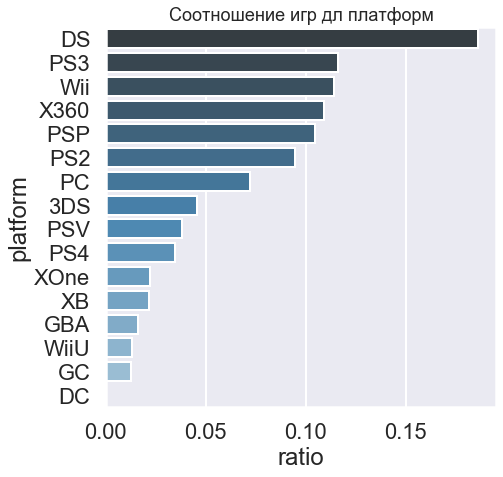

In [33]:
plat_count = pivot(data, 'platform', 'name', 'count')
barplot(plat_count, 'ratio', 'Соотношение игр дл платформ')

Больше всего игр было выпушено для DS, PS3, Wii, X360 и PSP

In [34]:
data_top_pl = df.pivot_table(index = 'platform',
                                  values='total_sales',
                                  aggfunc='sum').sort_values('total_sales', ascending=False).head(10)

In [35]:
data_top = data.query('platform in @data_top_pl.index')
data_top_final = data_top.groupby(['platform','year_of_release'], as_index=False)[['total_sales']].sum()

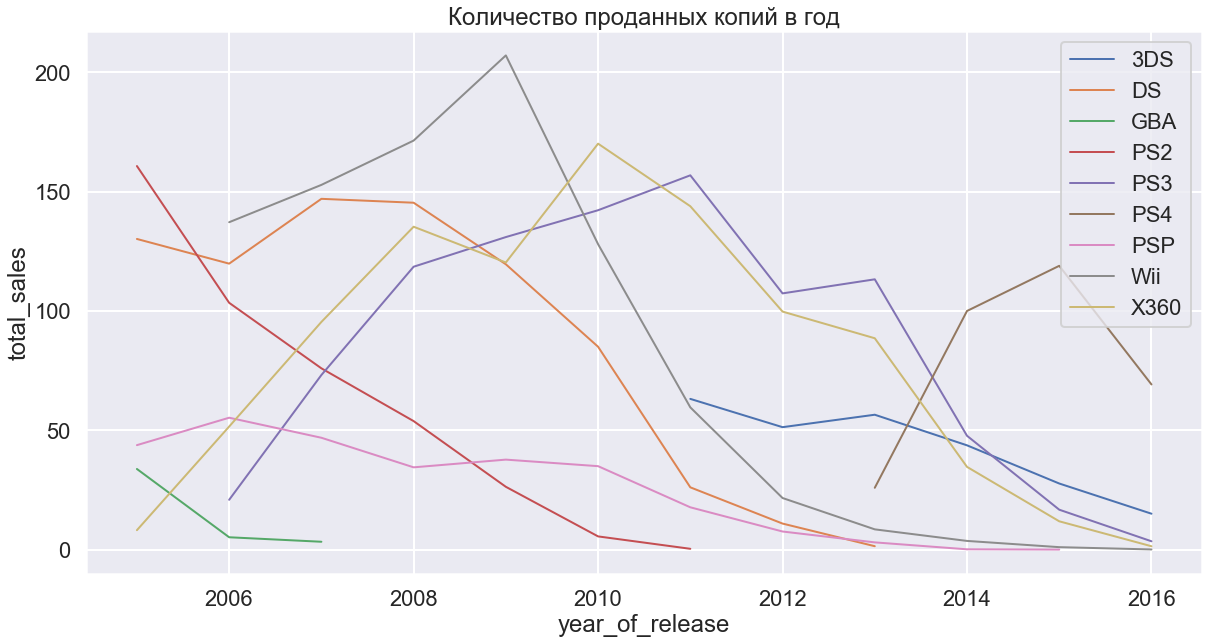

In [36]:
for i in data_top_final['platform'].unique():
    sns.set(rc={"figure.figsize":(20, 10)})
    sns.set_context("poster")
    plt.title('Количество проданных копий в год')
    sns.lineplot(data=data_top_final.loc[data_top_final['platform'] == i],
                 x='year_of_release',
                 y='total_sales',
                 label=i,
                 linewidth = 2)

Платформами с наибольшим количеством продаж оказались Wii, DS, X360 и PS3. Посмотрим на данные по продажам по каждой платформе.

In [37]:
platform_top_4 = data.query('(platform == "Wii") or (platform == "DS") or (platform == "X360") or (platform == "PS3")')

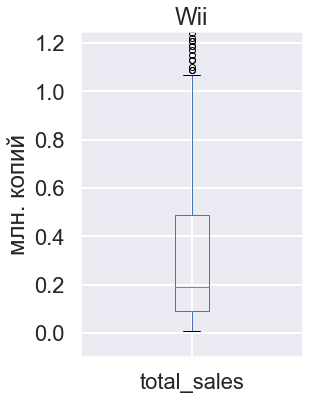

In [38]:
platform_top_4.loc[platform_top_4['platform'] == 'Wii'].boxplot(column='total_sales', figsize=(4,6))
plt.ylim(-0.1,1.25)
plt.ylabel('млн. копий')
plt.title('Wii')
plt.show()

Половина игр на платформее Wii продается от 100 до 500 тыс. копий , медиана около 200 тыс. копий, при этом отдельные игры создают очень большое стандартное отклонение. Это говорит о том что на данной платформе присутствуют игры ставшие бестселлерами.

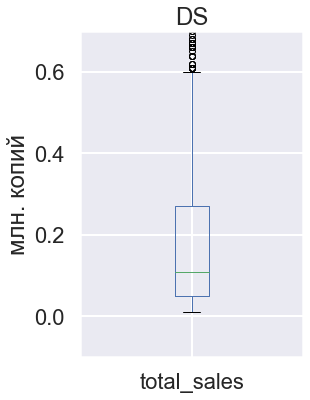

In [39]:
platform_top_4.loc[platform_top_4['platform'] == 'DS'].boxplot(column='total_sales', figsize=(4,6))
plt.ylim(-0.1,0.7)
plt.ylabel('млн. копий')
plt.title('DS')
plt.show()

Половина игр на платформее DS продается от 50 до 270 тыс. копий , медиана около 100 тыс. копий, при этом отдельные игры создают очень большое стандартное отклонение. Это говорит о том что на данной платформе присутствуют игры готорые были крайне популярны у пользователей.

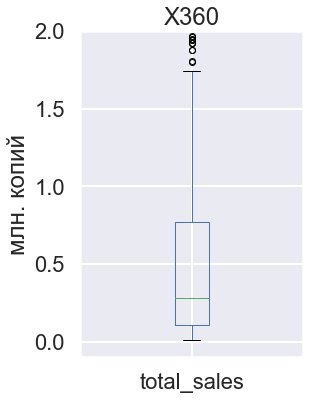

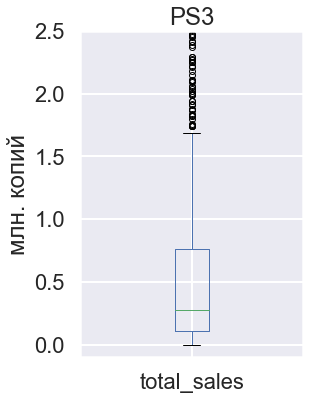

In [40]:
platform_top_4.loc[platform_top_4['platform'] == 'X360'].boxplot(column='total_sales', figsize=(4,6))
plt.ylim(-0.1,2)
plt.ylabel('млн. копий')
plt.title('X360')
plt.show()

platform_top_4.loc[platform_top_4['platform'] == 'PS3'].boxplot(column='total_sales', figsize=(4,6))
plt.ylim(-0.1,2.5)
plt.ylabel('млн. копий')
plt.title('PS3')
plt.show()

Лидерами по количеству продаж являются PS3 и X360. Данные продаж по этим платфорам похожи. Большинство значений входит в промежуток от 100 до 700 тыс. копий  и медиана около 300 тыс. копий.

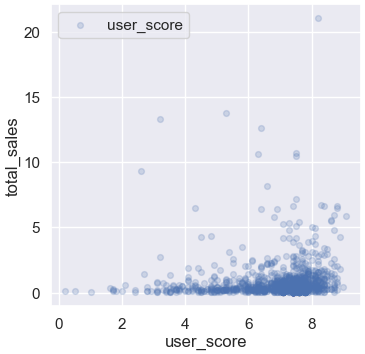

In [41]:
plt.figure(figsize=(8, 8), dpi=50)
plt.scatter(platform_top_4.loc[platform_top_4['platform'] == 'PS3', 'user_score'],
            platform_top_4.loc[platform_top_4['platform'] == 'PS3', 'total_sales'], label='user_score', s=70, alpha=0.2)
plt.xlabel('user_score')
plt.ylabel('total_sales')
plt.legend()
plt.show()

На графике мы видим увелечение количества проданных копий с ростом оценки пользователей, но это не правило, так же мы видим что большая часть игр с оценками от 6 до 8 не превышают 1 млн. проданых копий.

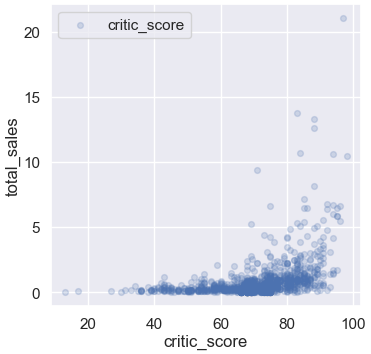

In [42]:
plt.figure(figsize=(8, 8), dpi=50)
plt.scatter(platform_top_4.loc[platform_top_4['platform'] == 'PS3', 'critic_score'],
            platform_top_4.loc[platform_top_4['platform'] == 'PS3', 'total_sales'], label='critic_score', s=70, alpha=0.2)
plt.xlabel('critic_score')
plt.ylabel('total_sales')
plt.legend()
plt.show()

Здесь мы видим похожую ситуацию, однако здесь количество продаж более выражено растет с увеличением рейтинга

In [43]:
score_sales_corr = platform_top_4.loc[:,['critic_score','user_score','total_sales']].corr()
score_sales_corr = pd.DataFrame(score_sales_corr['total_sales'])
score_sales_corr = score_sales_corr.query('total_sales < 1')
score_sales_corr

,total_sales
critic_score,0.213170
user_score,0.041806


В действительности ни одна из оценок сильно не коррелирует с количеством продаж.

In [44]:
platform_sales = platform_top_4.pivot_table(index='platform',
                                            values=['critic_score','user_score','total_sales'],
                                            aggfunc='median').sort_values('total_sales', ascending=False)
platform_sales

,critic_score,total_sales,user_score
platform,,,
X360,70.0,0.28,7.3
PS3,70.0,0.28,7.4
Wii,69.0,0.19,7.4
DS,69.0,0.11,7.5


Мы видим что оценки у игр на разных платформах близки друг к другу однако это никак не влияет на количество продаж.

### Распределение по жанрам

Посмотрим на распределение игр по жанрам

In [45]:
genre_count = pivot(platform_top_4, 'genre', 'platform', 'count')

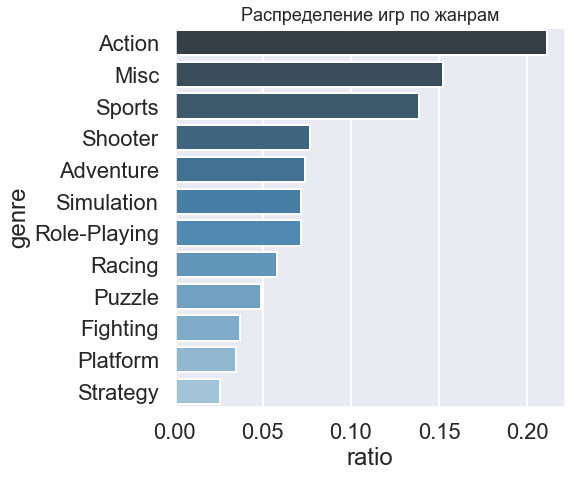

In [46]:
barplot(genre_count, 'ratio', 'Распределение игр по жанрам')

Мы видим что юлдьше всего игр игр в жанрах Action, Misc, Sports

In [47]:
genre_sales_pivot = pivot(platform_top_4, 'genre', 'total_sales','median')


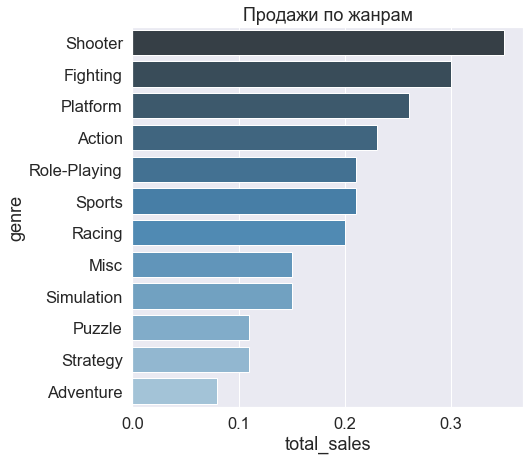

In [48]:
barplot(genre_sales_pivot, 'total_sales', 'Продажи по жанрам')

В большинстве своем лучше всего продаются игры жанра Action, Fighting, Platform, Shooter. Хуже всех Adventure.

## Портрет пользователя

### Северная Америка

Посмотрим на продажи исходя из жанра

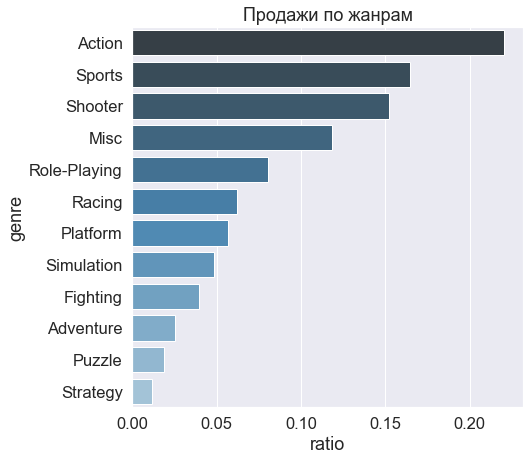

In [49]:
na_genre = pivot(data ,'genre','na_sales','sum')
barplot(na_genre,'ratio','Продажи по жанрам')

Как мы видим больше всего продается Action, Sports, Misc, Shooter, Role-Playing

Посмотрим на продажи по платформам

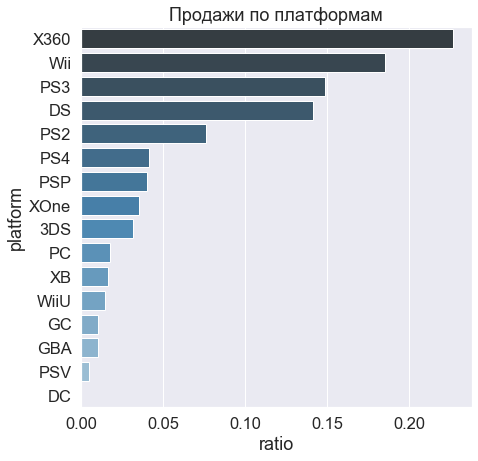

In [50]:
na_platform = pivot(data,'platform','na_sales','sum')
barplot(na_platform, 'ratio','Продажи по платформам')

Как мы видим самыми популярными платформами являются Wii, X360, DS, PS3 и PS2.

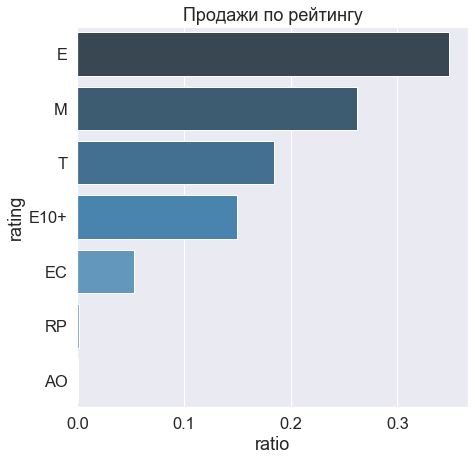

In [51]:
na_rating = pivot(data, 'rating', 'na_sales', 'sum')
barplot(na_rating, 'ratio', 'Продажи по рейтингу')

Исходя из графика видно что больше половины всех продаж с рейтингом Е и М.

Посмотрим как выглядят данные по продажам по жанрам исходя из рейтинга

In [52]:
rating_genre_na = pd.DataFrame(na_genre['na_sales'].head(5))
rating_genre_na = data.query('genre in @rating_genre_na.index')
rating_genre_na = rating_genre_na.pivot_table(index='genre',
                                        columns='rating',
                                        values='na_sales',
                                        aggfunc='sum')
rating_genre_na = rating_genre_na / data['na_sales'].sum()

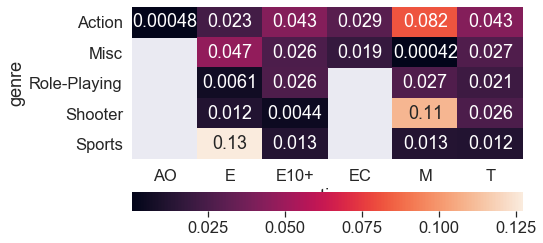

In [53]:
plt.figure(figsize=(7,4))
sns.heatmap(rating_genre_na, annot=True, cbar_kws= {'orientation': 'horizontal'})
sns.set(font_scale=0.8)
plt.show()

Как мы видим соотношение продаж по жанрам в зависимости от рейтинга сильно отличается. Это может быть связанно как с самим рейтингом так и с тем что игр данных жанров с некоторыми рейтингами мало выпускают.

In [54]:
rating_ratio = data.pivot_table(index='genre',
                               columns='rating',
                               values='name',
                               aggfunc='count')

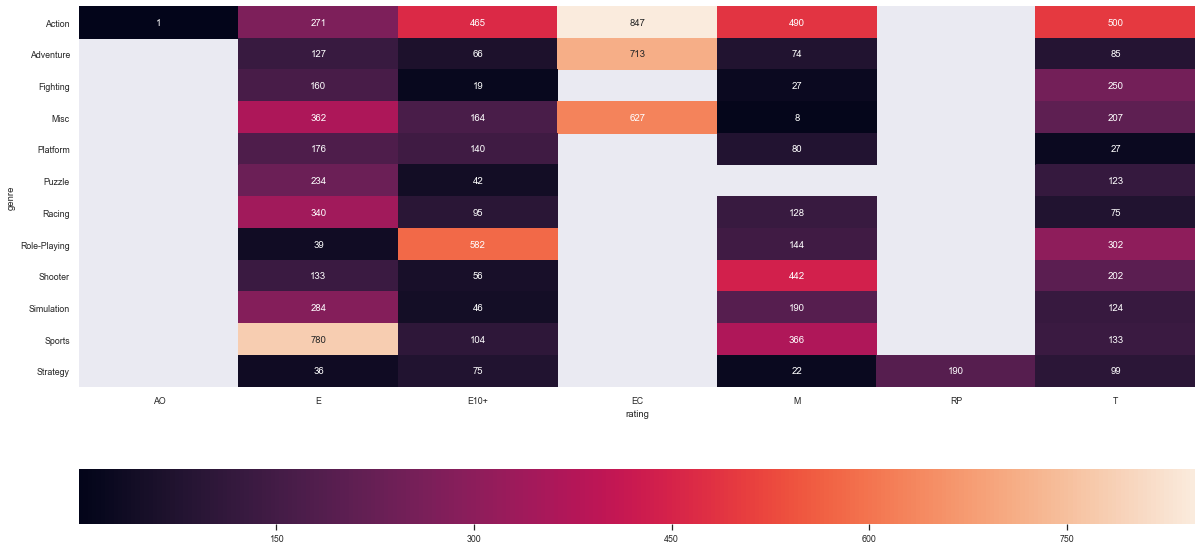

In [55]:
sns.heatmap(rating_ratio, annot=True, cbar_kws= {'orientation': 'horizontal'}, fmt='.3g')
plt.show()

Из графиков видно что соотношение игр с рейтингами к их их продажам совпадает только в жанре спорт. Шутеров же выпушенно больше с рейтином ЕС однако продажи показиывают что покупают больше с рейтингом M

#### Вывод

Пользователи из Северной Америки предпочитают играть на X360, Wii, PS3, DS и PS2 в игры жанра Action, Sports, Shooter, Misc, Role-Playing с рейтингом Е и M.

### Европа

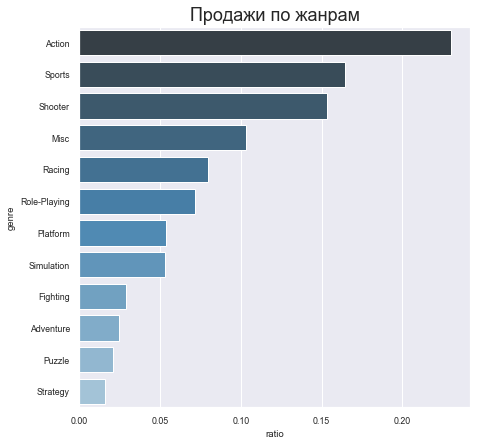

In [56]:
eu_genre = pivot(data ,'genre','eu_sales','sum')
barplot(eu_genre,'ratio','Продажи по жанрам')

Пользователи из европы отдают предпочтение тем же жанрам что и пользователи из Северной Америки(Action, Sports, Shooter, Misc) но вместо Role-Playing они предпочитают жанр Racing

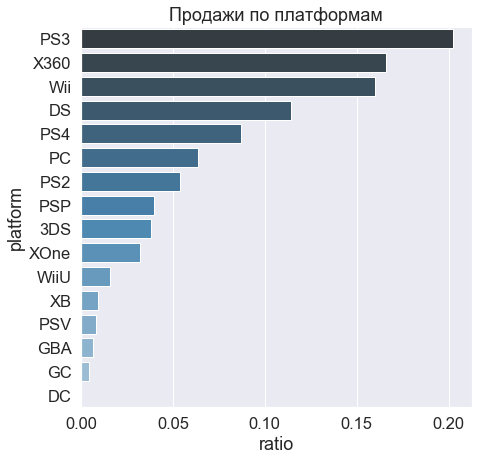

In [57]:
eu_platform = pivot(data,'platform','eu_sales','sum')
barplot(eu_platform, 'ratio','Продажи по платформам')

Европейские пользователи больше всего предпочитают PS3, за ним следуют Х360, Wii, DS и PS4. 

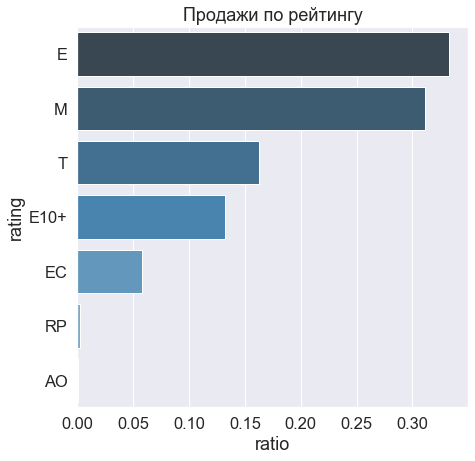

In [58]:
eu_rating = pivot(data, 'rating', 'eu_sales', 'sum')
barplot(eu_rating, 'ratio', 'Продажи по рейтингу')

В продажах так же как и в Северной Америке преобладают игры с рейтингом Е и М(пусть и с меньшим отстованием)

In [59]:
rating_genre_eu = pd.DataFrame(eu_genre['eu_sales'].head(5))
rating_genre_eu = data.query('genre in @rating_genre_eu.index')
rating_genre_eu = rating_genre_eu.pivot_table(index='genre',
                                        columns='rating',
                                        values='eu_sales',
                                        aggfunc='sum')
rating_genre_eu = rating_genre_eu / data['eu_sales'].sum()

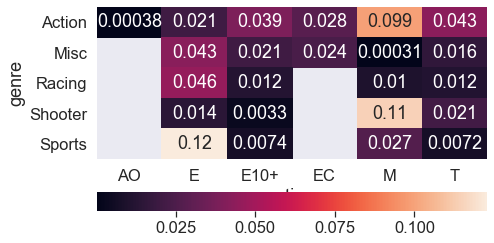

In [60]:
plt.figure(figsize=(7,4))
sns.heatmap(rating_genre_eu, annot=True, cbar_kws= {'orientation': 'horizontal'})
sns.set(font_scale=0.8)
plt.show()

Самыми популярными являются игры жанра спротивные игры рейтингом Е и игры жанров Action и Shooter с рейтингом М 

#### Вывод

Европейские пользователи больше всего предпочитают PS3, Х360, Wii, DS и PS4. Так же они отдают предпочтение жанрам Action, Sports, Shooter, Misc, Racing с рейтингами Е и М

### Япония

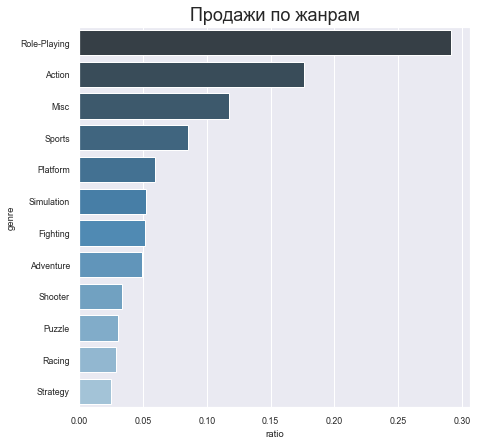

In [61]:
jp_genre = pivot(data ,'genre','jp_sales','sum')
barplot(jp_genre,'ratio','Продажи по жанрам')

Пользователи из Японии предпочитают игры жанров Role-Playing, Action, Misc, Sports, Platform

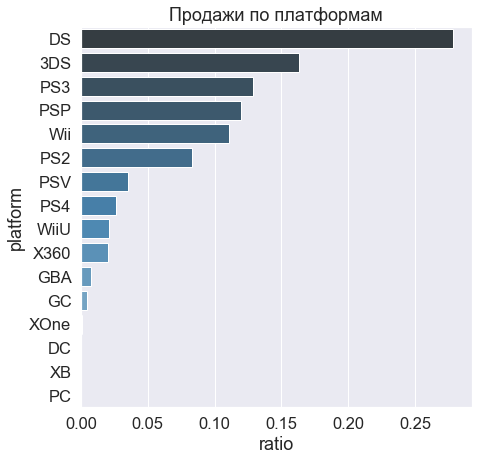

In [62]:
jp_platform = pivot(data,'platform','jp_sales','sum')
barplot(jp_platform, 'ratio','Продажи по платформам')

Из платформ они предпочитают DS, 3DS, PS3, PSP, Wii

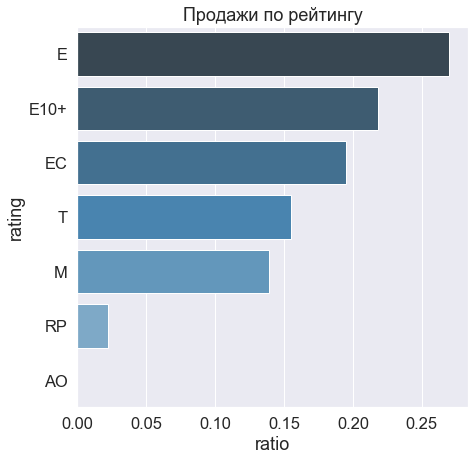

In [63]:
jp_rating = pivot(data, 'rating', 'jp_sales', 'sum')
barplot(jp_rating, 'ratio', 'Продажи по рейтингу')

Самые популярные рейтинги Е, Е10+ и ЕС

In [64]:
rating_genre_jp = pd.DataFrame(jp_genre['jp_sales'].head(5))
rating_genre_jp = data.query('genre in @rating_genre_jp.index')
rating_genre_jp = rating_genre_jp.pivot_table(index='genre',
                                        columns='rating',
                                        values='jp_sales',
                                        aggfunc='sum')
rating_genre_jp = rating_genre_jp / data['jp_sales'].sum()

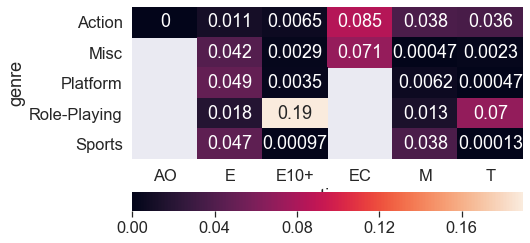

In [65]:
plt.figure(figsize=(7,4))
sns.heatmap(rating_genre_jp, annot=True, cbar_kws= {'orientation': 'horizontal'})
sns.set(font_scale=0.8)
plt.show()

Больше всего продаются ролевые игры с рейтингом Е10+, экшн и миск с рейтингом ЕС

#### Вывод

 Из платформ пользователи из Японии предпочитают DS, 3DS, PS3, PSP, Wii так же игры жанров Role-Playing, Action, Misc, Sports, Platform с рейтингами Е, Е10+ и ЕС

### Вывод

Пользователи из Северной Америки похожи на пользовотелей из Европы они  предпочитают играть на X360, Wii, PS3, DS и PS2 (вместо последней в Европе предпочитают PS 4) в игры жанра Action, Sports, Shooter, Misc, Role-Playing, в европе играют в те же игры только вместо Role_Playing выбирают Racing с рейтингом Е и M.
А пользователи  из Японии отличаются от других континентов, они предпочитают DS, 3DS, PS3, PSP, Wii так же игры жанров Role-Playing, Action, Misc, Sports, Platform с рейтингами Е, Е10+ и ЕС.Из за ярко выраженных различий в продаже игр по жанрам исходя из рейтинга мы можем сделать вывод что рейтинг не играет роль только в Японии. Так как количество игр выпушенных для каждого рейтинга по жанрам совпадает с продажами только в Японии на остальных рынках значения различаются.

## Проверка гипотез

### Первая гипотеза

Узнаем средние пользовательские рейтинги платформ Xbox One и PC одинаковые или нет.

In [66]:
xone_score = data.loc[data['platform'] == 'XOne', 'user_score']
pc_score = data.loc[data['platform'] == 'PC', 'user_score']

Зададим критический уровень статистической значимости, проведем т-тест и расчитаем p-value.

In [67]:
alpha = 0.05
result = st.ttest_ind(xone_score, pc_score)

Сформулируем гипотезы. H0 - средние пользовательские рейтинги Xbox One не отличаются от средних пользовательских рейтингов PC. H1 - средние пользовательские рейтинги Xbox One отличаются от средних пользовательских оценок PC.

In [68]:
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.008598680263656606
Отвергаем нулевую гипотезу


#### Вывод

Исходя из проверки мы можем утверждать что средние пользовательские оценки Xbox One и PC отличаются

### Вторая гипотеза

Узнаем средние пользовательские рейтинги жанров Action и Sports разные или нет

In [69]:
action_score = data.loc[data['genre'] == 'Action', 'user_score']
sports_score = data.loc[data['genre'] == 'Sports', 'user_score']

Зададим критический уровень статистической значимости, проведем т-тест и расчитаем p-value.

In [70]:
alpha = 0.05
result = st.ttest_ind(action_score, sports_score)

Сформулируем гипотезы. H0 - средние пользовательские рейтинги Action не отличаются от средних пользовательских рейтингов Sports. H1 - средние пользовательские рейтинги Action отличаются от средних пользовательских оценок Sports.

In [71]:
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 2.1132264707429313e-08
Отвергаем нулевую гипотезу


#### Вывод

Исходя из проверки мы можеи утверждать что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Количество игр начало постепенно расти начиная с 1990 года, вплоть до 2010 после чего начался спад. А наибольшее количество игр выпускалось с 2005 по 2010 год. Платформами с наибольшим количеством продаж оказались Wii, DS, X360 и PS3. В данных о продажах по этим платформам большое стандартное отклонение, это говорит о том что на данных платформах присутствуют игры ставшие бестселлерами.
Пользователи из Северной Америки похожи на пользовотелей из Европы они предпочитают играть на X360, Wii, PS3, DS и PS2 (вместо последней в Европе предпочитают PS 4) в игры жанра Action, Sports, Shooter, Misc, Role-Playing, в европе играют в те же игры только вместо Role_Playing выбирают Racing с рейтингом Е и M. А пользователи из Японии отличаются от других континентов, они предпочитают DS, 3DS, PS3, PSP, Wii так же игры жанров Role-Playing, Action, Misc, Sports, Platform с рейтингами Е, Е10+ и ЕС.Из за ярко выраженных различий в продаже игр по жанрам исходя из рейтинга мы можем сделать вывод что рейтинг не играет роль только в Японии. Так как соотношение игр выпушенных для каждого рейтинга по жанрам совпадает с соотношением продаж только в Японии на остальных рынках значения различаются.



Исходя из проверки гипотез мы можем утверждать что средние пользовательские оценки Xbox One и PC отличаются, так же как и средние пользовательские рейтинги жанров Action и Sports.